### Problem statement: 
To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis. So build a multiclass classification model using a custom convolutional neural network in TensorFlow

### Data Summary:

The dataset consists of 2357 images of malignant and benign oncological diseases, which were formed from the International Skin Imaging Collaboration (ISIC). All images were sorted according to the classification taken with ISIC, and all subsets were divided into the same number of images, with the exception of melanomas and moles, whose images are slightly dominant.

The data set contains the following diseases:

Actinic keratosis
Basal cell carcinoma
Dermatofibroma
Melanoma
Nevus
Pigmented benign keratosis
Seborrheic keratosis
Squamous cell carcinoma
Vascular lesion

### Importing all the important libraries

In [44]:
#Installing tenserflow and restarting kernel
!pip install tensorflow==2.5.0


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
#Checking if tenserflow is installed
!pip show tensorflow

Name: tensorflow
Version: 2.5.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.8/dist-packages
Requires: wheel, keras-preprocessing, astunparse, absl-py, grpcio, opt-einsum, h5py, tensorboard, protobuf, google-pasta, flatbuffers, six, gast, keras-nightly, typing-extensions, termcolor, wrapt, tensorflow-estimator, numpy
Required-by: kapre


### Importing necessary libraries

In [2]:
#Importing necessary libraries required for model building and evaluation
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.python.keras.layers.normalization import BatchNormalization
from tensorflow.python.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
import warnings
warnings.filterwarnings('ignore')


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/gdrive


In [4]:
#unzip the dataset
!unzip "/content/gdrive/MyDrive/CNN_assignment.zip" > /dev/null


### Importing Skin Cancer Data
#### To do: Take necessary actions to read the dat

In [5]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/")
data_dir_test = pathlib.Path('/content/Skin cancer ISIC The International Skin Imaging Collaboration/Test/')

In [6]:
#Printing image count in train and test dataset
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [7]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [8]:
## Defining train dataset here using seed=123 while creating dataset using tf.keras.preprocessing.image_dataset_from_directory
## We resize images to the size img_height*img_width, 
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [9]:
## Defining validation dataset here using seed=123 while creating dataset using tf.keras.preprocessing.image_dataset_from_directory
## We resize images to the size img_height*img_width, 
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [10]:
# Listing out all the classes of skin cancer and store them in a list. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### visualizing one instance of all the nine classes present in the dataset

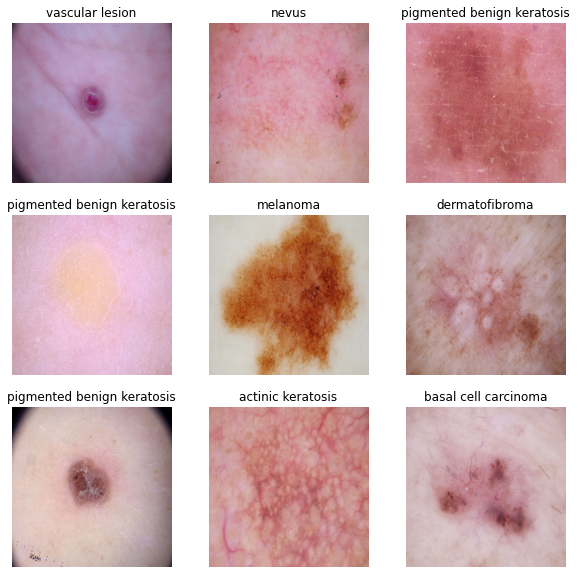

In [11]:
### using training data to visualize

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [12]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Creating the model
####  Creating a CNN model, which can accurately detect 9 classes present in the dataset. Using```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [13]:
preprocessing_layers = [
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3))
]

In [14]:
### Model building to detect 9 classes in dataset

input_shape = (180,180,3)
lr = 1e-5
init = 'normal'
activ = 'relu'

model = Sequential()
model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3)))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

## Number of classes is 9
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 178, 178, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 176, 176, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 88, 88, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 86, 86, 64)        18496     
_________________________________________________________________
batch_normalization (BatchNo (None, 86, 86, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 43, 43, 64)        0

### Compile the model
Choosing Adam optimiser and binary_crossentropy loss function for model training 
Adam optimization: is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments.
#categorical_crossentropy: Used as a loss function for multi-class classification model where there are two or more output labels.

In [15]:
### Choosing Adam optimiser and binary_crossentropy loss function for model training 

optimizer = 'adam'
loss_fn = "binary_crossentropy"
model.compile(optimizer=optimizer,
              loss=loss_fn,
              metrics=['accuracy'])


In [16]:
# Viewing the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 178, 178, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 176, 176, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 88, 88, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 86, 86, 64)        18496     
_________________________________________________________________
batch_normalization (BatchNo (None, 86, 86, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 43, 43, 64)        0

### Train the model

In [17]:
#Training model with 20 epochs
epochs = 20
batch_size = 32

history = model.fit(
  train_ds,
  batch_size=batch_size,
  validation_data=val_ds,
  epochs=epochs
)


Epoch 1/20
56/56 [==============================] - 29s 123ms/step - loss: -68561.2500 - accuracy: 0.1719 - val_loss: -64192.9258 - val_accuracy: 0.1499
Epoch 2/20
56/56 [==============================] - 3s 62ms/step - loss: -783893.9375 - accuracy: 0.1724 - val_loss: -612628.1875 - val_accuracy: 0.1499
Epoch 3/20
56/56 [==============================] - 3s 61ms/step - loss: -2901779.2500 - accuracy: 0.1724 - val_loss: -2142277.0000 - val_accuracy: 0.1499
Epoch 4/20
56/56 [==============================] - 3s 62ms/step - loss: -7093016.0000 - accuracy: 0.1724 - val_loss: -6376794.0000 - val_accuracy: 0.1499
Epoch 5/20
56/56 [==============================] - 3s 62ms/step - loss: -14265344.0000 - accuracy: 0.1724 - val_loss: -14968674.0000 - val_accuracy: 0.1499
Epoch 6/20
56/56 [==============================] - 3s 62ms/step - loss: -24954364.0000 - accuracy: 0.1724 - val_loss: -38597652.0000 - val_accuracy: 0.1499
Epoch 7/20
56/56 [==============================] - 3s 62ms/step - los

### Visualizing training results

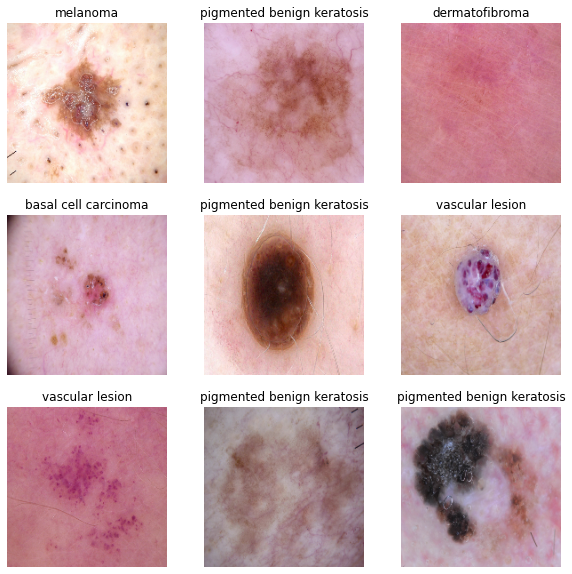

In [18]:
#Visualizing the results after traiing the model
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

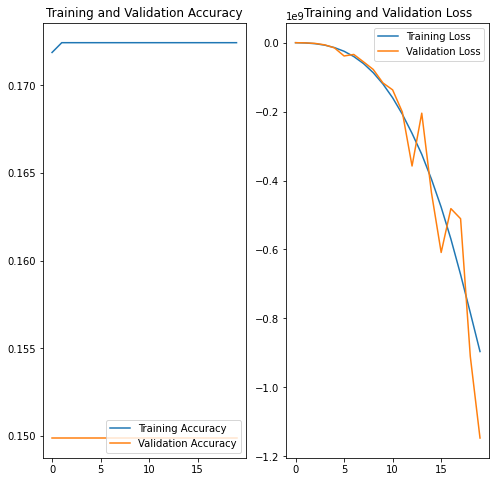

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### findings after the model fit, see if there is an evidence of model overfit or underfit

### we can clearly see that model Overfit and we need to chose right data augumentation strategy

In [20]:
# after you have analysed the model fit history for presence of underfit or overfit, we would need to choose an appropriate data augumentation strategy. 

loss, accuracy = model.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Loss: ",loss)
print("Validation Loss", loss_v)


# Therefore we can clearly see that model Overfit and we need to chose right data augumentation strategy

14/14 [==============================] - 0s 17ms/step - loss: -1147000704.0000 - accuracy: 0.1499
Accuracy:  0.1724330335855484
Validation Accuracy:  0.14988814294338226
Loss:  -1112926976.0
Validation Loss -1147000704.0


In [21]:
# visualizing how your augmentation strategy works for one instance of training image.


datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

image_class = ['nevus','melanoma','basal_cell_caricoma','actinic_keratosis','vasc_lesion','dermatofibroma', 'pigmented_keratosis', 'seborrheic_keratosis', 'squamous_carci']

train_batches = datagen.flow_from_directory(data_dir_train, 
    target_size = (180,180),
    classes = image_class,
    batch_size = 64
 )

valid_batches = datagen.flow_from_directory(data_dir_test, 
    target_size = (180,180),
    classes = image_class,
    batch_size = 64
)


Found 890 images belonging to 9 classes.
Found 48 images belonging to 9 classes.


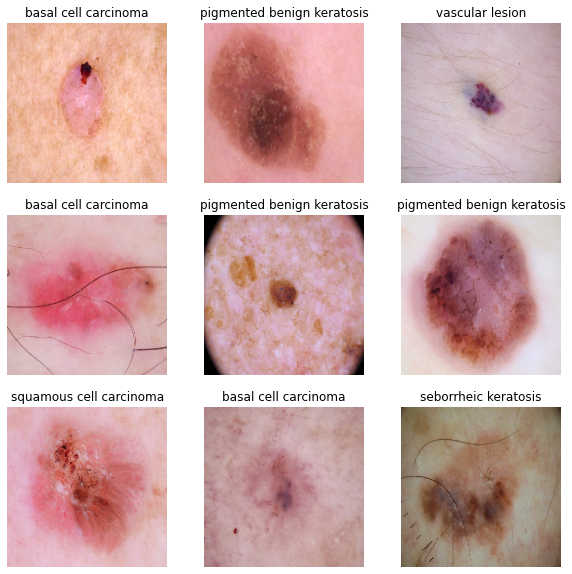

In [22]:
# visualizing how your augmentation strategy works for one instance of training image.

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")



### Create the model, compile and train the model


In [23]:
## using Dropout layer as there is an evidence of overfitting in your findings

model = Sequential()

# Increse the model size by adding another 32 layer
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=input_shape))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'))
# Max Pool size of 2*2
model.add(MaxPool2D(pool_size=(2, 2)))
# Adding Dropout Layer
model.add(Dropout(0.25))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding = 'Same'))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding = 'Same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(9, activation='softmax'))

model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 180, 180, 32)      896       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 180, 180, 32)      9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 90, 90, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 90, 90, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 90, 90, 64)        18496     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 90, 90, 64)        36928     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 45, 45, 64)       

### Compiling the model

In [24]:

## model compilation

optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])


In [25]:
# Set a learning rate annealer
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
    patience=3, 
    verbose=1, 
    factor=0.5, 
    min_lr=0.00001)

### Training the model

In [26]:
## training model for 20 epochs
epochs = 20
batch_size = 10
history = model.fit(train_batches,
  epochs = epochs, verbose = 1, validation_data=valid_batches , callbacks=[learning_rate_reduction])

Epoch 1/20
14/14 [==============================] - 40s 3s/step - loss: 248.2497 - accuracy: 0.4180 - val_loss: 1.3132 - val_accuracy: 0.3333
Epoch 2/20
14/14 [==============================] - 36s 3s/step - loss: 1.7998 - accuracy: 0.4326 - val_loss: 1.9345 - val_accuracy: 0.3125
Epoch 3/20
14/14 [==============================] - 31s 2s/step - loss: 1.0854 - accuracy: 0.4876 - val_loss: 2.0833 - val_accuracy: 0.1042
Epoch 4/20
14/14 [==============================] - 30s 2s/step - loss: 1.0464 - accuracy: 0.4730 - val_loss: 2.0896 - val_accuracy: 0.3125

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 5/20
14/14 [==============================] - 30s 2s/step - loss: 0.9869 - accuracy: 0.5191 - val_loss: 2.0087 - val_accuracy: 0.2917
Epoch 6/20
14/14 [==============================] - 29s 2s/step - loss: 0.9653 - accuracy: 0.5079 - val_loss: 1.9377 - val_accuracy: 0.3333
Epoch 7/20
14/14 [==============================] - 30s 2s/step - loss: 0.925

### Visualizing the results

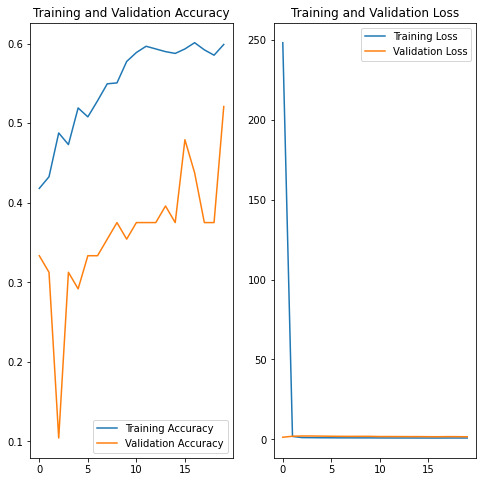

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

<Figure size 720x720 with 0 Axes>

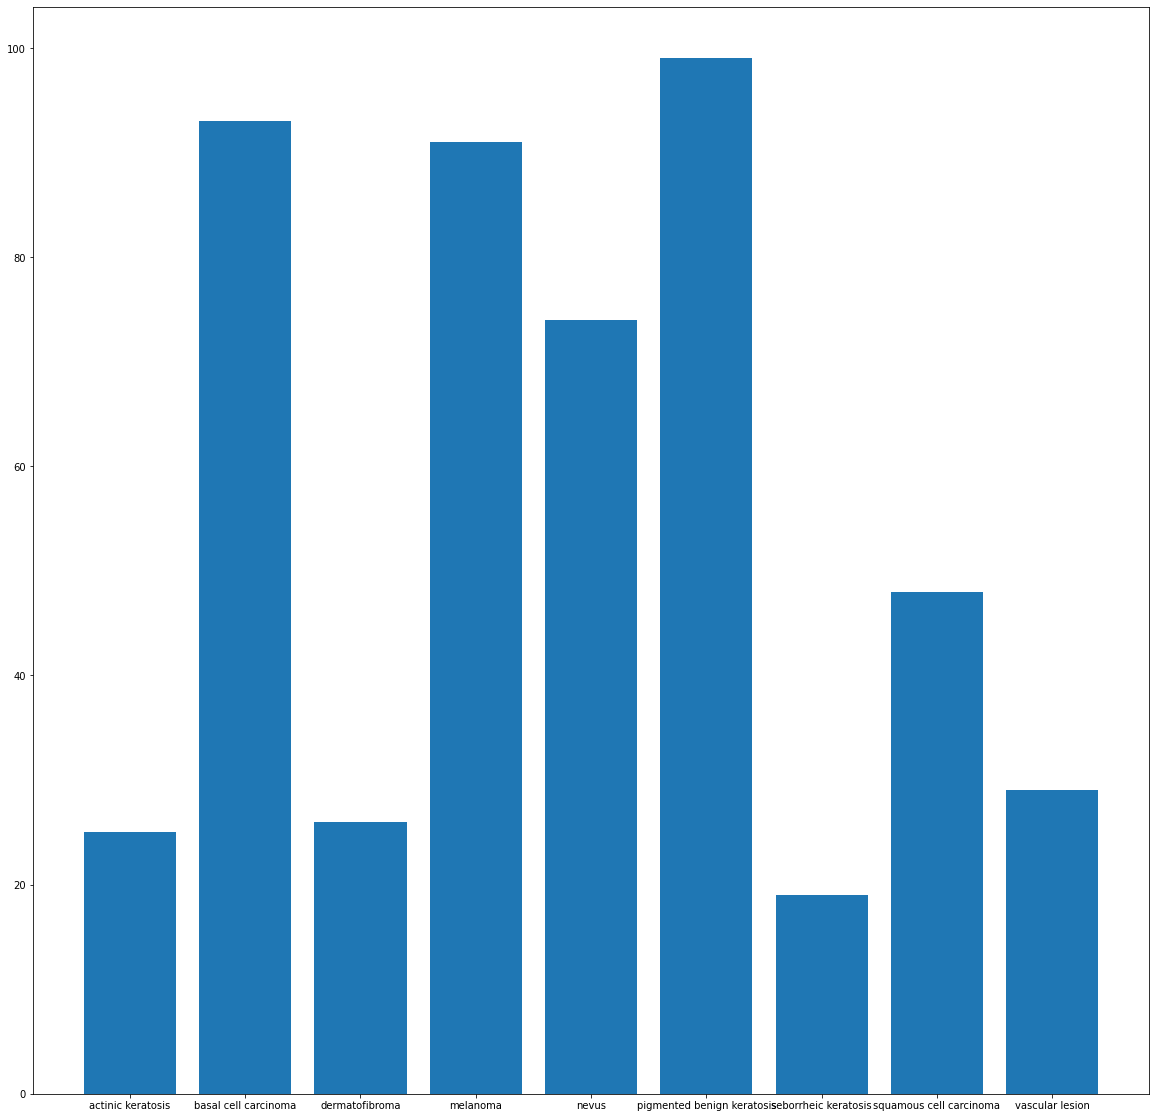

In [28]:
## Finding the distribution of classes in the training dataset

data = dict()

for i in class_names:
  data[i] = []

plt.figure(figsize=(10, 10))
for images, labels in train_ds:
  for i in range(9):
    data[class_names[labels[i]]].append(images[i].numpy().astype("uint8"))

for i in data:
  data[i] = len(data[i]) 

f = plt.figure()
f.set_figwidth(20)
f.set_figheight(20)

plt.bar(range(len(data)), list(data.values()), align='center')
plt.xticks(range(len(data)), list(data.keys()))
plt.show()

#### **Todo:** Write your findings here: 
We can definately see class imbalance here, so need to rectify it 
#### - Which class has the least number of samples?-
Actinic Keratosos and Seborrheic keratosis
#### - Which classes dominate the data in terms proportionate number of samples?
Pigmented benign keratosis dominates the data of count more than 100 in training


####  Rectifying the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [29]:
# installing Augmentor
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [30]:
path_to_training_dataset="/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FED5E667F70>: 100%|██████████| 500/500 [00:20<00:00, 24.46 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FED626DCF10>: 100%|██████████| 500/500 [00:21<00:00, 22.76 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FED5E6E4D60>: 100%|██████████| 500/500 [00:21<00:00, 23.43 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x7FED62140E80>: 100%|██████████| 500/500 [01:33<00:00,  5.37 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FED5E775A30>: 100%|██████████| 500/500 [01:15<00:00,  6.65 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FED5E79BDF0>: 100%|██████████| 500/500 [00:16<00:00, 30.27 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FED620CE400>: 100%|██████████| 500/500 [00:40<00:00, 12.23 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FED62081F10>: 100%|██████████| 500/500 [00:16<00:00, 31.03 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FED621A9700>: 100%|██████████| 500/500 [00:16<00:00, 29.62 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [31]:
# total count of augmented images.
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [32]:
# distribution of augmented data after adding new images to the original training data.
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000317.jpg_010d527f-2978-46b3-95a5-1d25bc06457e.jpg',
 '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0026212.jpg_a3ac2c6e-3029-48cf-9d5d-3aceec66e9fe.jpg',
 '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000354.jpg_e336aa34-3884-40e5-b997-dea2548c1755.jpg',
 '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000437.jpg_39e0b362-3c50-4ed3-8cb9-04e0cf4d096b.jpg',
 '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000084.jpg_0898fbe0-3ae3-4b56-bddd-84df917cb429.jpg',
 '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000361.jpg_f1fe716a-84d8-4199-953a-34bbfc058539.jpg'

In [33]:
# distribution of augmented data after adding new images to the original training data.
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',


In [34]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [35]:
# copying path and label dataframe to a new dataframe to analyse results
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = df2

In [36]:
# added 500 images to all the classes to maintain some class balance
new_df['Label'].value_counts()

nevus                         500
actinic keratosis             500
dermatofibroma                500
basal cell carcinoma          500
vascular lesion               500
squamous cell carcinoma       500
pigmented benign keratosis    500
seborrheic keratosis          500
melanoma                      500
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [37]:
# defiing the parameters
batch_size = 32
img_height = 180
img_width = 180

### Create a training dataset

In [38]:
# recreating train dataset 
data_dir_train="/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


### Create a validation dataset

In [39]:
# Recreating validation dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


### Creating model including normalization

In [40]:
## model creation with normalization
model = Sequential()

# Increse the model size by adding another 32 layer
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=input_shape))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'))

# Max Pool size of 2*2
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(BatchNormalization())
# Adding Dropout Layer
model.add(Dropout(0.25))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding = 'Same'))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding = 'Same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(1, activation='softmax'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 180, 180, 32)      896       
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 180, 180, 32)      9248      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 90, 90, 32)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 90, 90, 32)        128       
_________________________________________________________________
dropout_5 (Dropout)          (None, 90, 90, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 90, 90, 64)        18496     
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 90, 90, 64)       

### Compiling  model (Choosing Adam optimizer and categorical_crossentrop loss function )

In [41]:
## Model compilation
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])


### Training model

In [42]:
#Model training
epochs = 30

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
    patience=3, 
    verbose=1, 
    factor=0.5, 
    min_lr=0.00001)

batch_size = 10
history = model.fit(train_ds,
  epochs = epochs, verbose = 1, validation_data=val_ds , callbacks=[learning_rate_reduction])


Epoch 1/30
169/169 [==============================] - 41s 221ms/step - loss: 0.0000e+00 - accuracy: 0.1337 - val_loss: 0.0000e+00 - val_accuracy: 0.1151
Epoch 2/30
169/169 [==============================] - 36s 207ms/step - loss: 0.0000e+00 - accuracy: 0.1337 - val_loss: 0.0000e+00 - val_accuracy: 0.1151
Epoch 3/30
169/169 [==============================] - 37s 212ms/step - loss: 0.0000e+00 - accuracy: 0.1337 - val_loss: 0.0000e+00 - val_accuracy: 0.1151
Epoch 4/30
169/169 [==============================] - 36s 209ms/step - loss: 0.0000e+00 - accuracy: 0.1337 - val_loss: 0.0000e+00 - val_accuracy: 0.1151

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 5/30
169/169 [==============================] - 36s 209ms/step - loss: 0.0000e+00 - accuracy: 0.1337 - val_loss: 0.0000e+00 - val_accuracy: 0.1151
Epoch 6/30
169/169 [==============================] - 36s 209ms/step - loss: 0.0000e+00 - accuracy: 0.1337 - val_loss: 0.0000e+00 - val_accuracy: 0.1151
E

###  Visualizing the model results

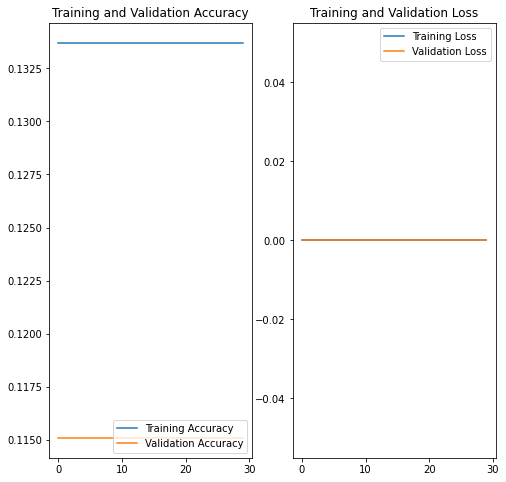

In [43]:
# Visualize results after model training
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

####  Analyzing results here. Did you get rid of underfitting/overfitting? Did class rebalance help?


Yes, we got rid of overfitting using data augmentation. 

Actinic Keratosos and Seborrheic keratosis class had least number of samples

Pigmented benign keratosis dominated the data of count more than 100 in training

The class rebalance helped in reducing overfititng of the data and so the loss is beng reduced But it reduced the Acurracy very low

In the begining we tried without the ImageDataGenerator which made data to over fit at high ratio

Then we used dropout and ImageDataGenerator which reduced the overfitting

At end we used Batch Normalization and Augumentation which really helped in carry forward and reducing overfit